In [1]:
import torch
from torch import nn

import numpy as np
from matplotlib import pyplot as plt

from PIL import Image
import cv2

In [2]:
import torch
import gc

def clear_gpu(is_del=False):
    # Delete all variables referencing GPU tensors
    gc.collect()  # Force garbage collection
    torch.cuda.empty_cache()  # Free cached memory

    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()

    if (is_del):
        for obj in gc.get_objects():
            if torch.is_tensor(obj) and obj.is_cuda:
                del obj
        gc.collect()
        torch.cuda.empty_cache()

    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()


def check_gpu_objects():
    gpu_tensors = [obj for obj in gc.get_objects() if torch.is_tensor(obj) and obj.is_cuda]
    print(f"Number of GPU tensors: {len(gpu_tensors)}")
    for i, tensor in enumerate(gpu_tensors[:5]):  # Print only the first 5
        print(f"Tensor {i}: {tensor.size()}, {tensor.dtype}, {tensor.device}, {tensor.numel()*tensor.element_size()/2**20}MB")

check_gpu_objects()
clear_gpu(True)

/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/__init__.py:1113: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/cuda/memory.py:417: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Number of GPU tensors: 0


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

(3024, 3024, 3)

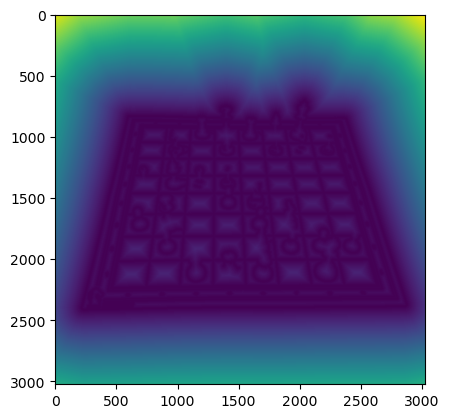

In [4]:
image_file_path = "data/image1.jpg"
img = np.array(Image.open(image_file_path))
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img_blur = cv2.GaussianBlur(img_gray, (3, 3), 1)
img_edge = cv2.Canny(img_gray, 100, 700)
d = torch.tensor(cv2.distanceTransform(255-img_edge, cv2.DIST_L2, 5))
plt.imshow(d.cpu());
# plt.imshow(img_edge);
img.shape

In [5]:
src_pts = torch.tensor([
    [0,0],
    [255,0],
    [255,255],
    [0,255],
], dtype=torch.float32)

def get_M(dst_pts):
    assert src_pts.shape == (4, 2) and dst_pts.shape == (4, 2), "Source and destination points must be (4,2)"
    
    # Construct the A matrix (8x8) and B vector (8x1)
    A = []
    B = []
    
    for (x_src, y_src), (x_dst, y_dst) in zip(src_pts, dst_pts):
        A.append([x_src, y_src, 1, 0, 0, 0, -x_dst*x_src, -x_dst*y_src])
        A.append([0, 0, 0, x_src, y_src, 1, -y_dst*x_src, -y_dst*y_src])
        B.append(x_dst)
        B.append(y_dst)
    
    A = torch.tensor(A, dtype=torch.float32)  # Make sure A is trainable
    B = torch.tensor(B, dtype=torch.float32)

    # # Solve Ax = B using torch.linalg.lstsq
    # X = torch.linalg.lstsq(A, B).solution[:8]
    # Solve Ax = B using torch.linalg.solve (instead of lstsq)
    X = torch.linalg.solve(A, B)


    # Reshape to form 3x3 matrix
    M = torch.cat([X, torch.tensor([1.0])], dim=0).reshape(3, 3)

    return M

def get_grid(grid_size=256):
    H, W = grid_size, grid_size

    # Create coordinate grids
    x_coords = torch.arange(W).view(1, W).expand(H, W)
    y_coords = torch.arange(H).view(H, 1).expand(H, W)

    # Stack to form (W, H, 2)
    return torch.stack((y_coords, x_coords), dim=-1).to(torch.float32)  

def reverseWarp_corrdinates(coords: torch.Tensor, M): # M is the inversing one
    """Warp (x', y') back to (x, y) using the inverse transform."""
    W, H = coords.shape[0], coords.shape[1]  # Extract dimensions

    expanded_coords = torch.cat([coords, torch.ones_like(coords[:,:,[0]])], dim=2)

    # Reshape coords from (3, W, H) → (3, W*H) for matrix multiplication
    # coords_flat = t.permute(2,0,1).view(3, W*H)  # Shape (3, W*H)
    coords_flat = expanded_coords.flatten(0,1).T  # Shape (3, W*H)

    # Perform matrix multiplication
    warped = (M @ coords_flat).T.unflatten(0, (W,H)).permute(1,0,-1)  # Shape (3, W*H)

    return warped / warped[:,:,[2]]


def chessboard(coords):
    p = 100
    out = (torch.relu(torch.cos((np.pi/16) * coords[:,:,0]))) ** p + (torch.relu(torch.cos((np.pi/16) * coords[:,:,1]))) ** p

    out[torch.logical_or(coords[:,:,0] < 0, coords[:,:,0] >= 256)] = 0
    out[torch.logical_or(coords[:,:,1] < 0, coords[:,:,1] >= 256)] = 0

    return out

def calcError(d, warpped):
    return torch.mean(d**2 * warpped)

def calcError_from_dst(d, dst):
    img_size = d.shape[0]

    d_device = d.device

    M = get_M(dst)
    grid = get_grid(img_size)
    new_coords = reverseWarp_corrdinates(grid, M.inverse())[:,:,:2]
    warpped = chessboard(new_coords)
    loss = calcError(d, warpped.to(d_device))
    
    return loss

In [6]:
dst = torch.tensor([
    [720,920],
    [2264,935],
    [2634,2217],
    [470,2237],
], dtype=torch.float32)

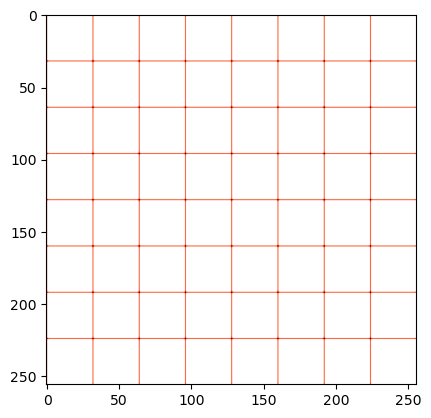

In [7]:
grid = get_grid(256)
board = chessboard(grid)
plt.imshow(board, alpha=(board>.5).float(), cmap='Reds');

tensor(1.3997)

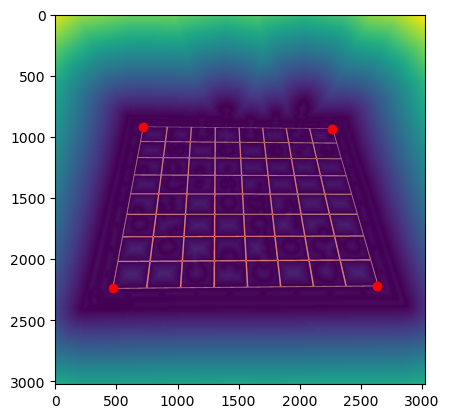

In [8]:
# %%timeit

# loss = calcError_from_dst(d, dst)

M = get_M(dst)
grid = get_grid(3024)
new_coords = reverseWarp_corrdinates(grid, M.inverse())[:,:,:2]
warpped = chessboard(new_coords)
loss = calcError(d, warpped)

plt.imshow(d.cpu());
plt.imshow(warpped, alpha=(warpped>.5).float(), cmap='Reds');
plt.scatter(dst[:,0], dst[:,1], c='red');
loss

In [9]:
H, W = 3024, 3024

class BoardDetector(nn.Module):
    def __init__(self, I_Shape=(W, H)):
        super().__init__()

        self.I_shape = I_Shape
        self.I_Size = I_Shape[0] * I_Shape[1]
        
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 5, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(5, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(8, 5, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(5, 1, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(4),
        )

        self.linear_stack = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(11*11, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_stack(self.conv_blocks(x)).view(x.shape[0], 4, 2)
        # return self.conv_blocks(x)

In [10]:
# %%timeit

x = torch.rand(1, 3024,3024).to(device)
bd = BoardDetector().to(device)
y = bd(x)
# y = bd(d.unsqueeze(dim=0))
y.shape

torch.Size([1, 4, 2])

In [ ]:
from ChessReD_Dataset import ChessReDDataset
dataset = ChessReDDataset(label_key="corners")
dataloader = dataset.getLoader()
len(dataset)

2078

In [16]:
clear_gpu(True)

In [17]:
clear_gpu(True)

bd = BoardDetector().to(device)
iter_count = 0
for X, y_prime in dataloader:
    x = torch.mean(X.to(torch.float32), dim=3).unsqueeze(1).to(device)
    y_prime = bd(x)
    print(y_prime.shape)
    del x,y_prime,X,y
    clear_gpu(True)
    break

    iter_count += 1
    if (iter_count == 10):
        break

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.36 GiB. GPU 0 has a total capacity of 3.81 GiB of which 955.56 MiB is free. Including non-PyTorch memory, this process has 2.36 GiB memory in use. Of the allocated memory 2.18 GiB is allocated by PyTorch, and 118.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)